In [16]:
# Resolve paths from data_tools directory
import os
import sys

module_path = os.path.abspath(os.path.join("../data_tools"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [17]:
import pandas as pd
import numpy as np
raw_df = pd.read_csv("../saved/5m_journal_conf_comp_sci_with_rank_features.csv", index_col='PaperId.1')
raw_df.shape


(282456, 35)

In [68]:
raw_df.columns

Index(['PaperId', 'Abstract', 'Author_1', 'Author_10', 'Author_11', 'Author_2',
       'Author_3', 'Author_4', 'Author_5', 'Author_6', 'Author_7', 'Author_8',
       'Author_9', 'CitationCount', 'CitationCountPerYear', 'FieldOfStudy_0',
       'FieldOfStudy_1', 'FieldOfStudy_2', 'FieldOfStudy_3', 'FieldOfStudy_4',
       'FieldOfStudy_5', 'FirstPage', 'JournalName', 'LastPage',
       'PublishedDate', 'Publisher', 'Rank', 'Title', 'YearsSincePublication',
       'AuthorProminence', 'MagBin', 'CitationBin', 'AuthorRank',
       'JournalNameRank', 'PublisherRank'],
      dtype='object')

In [80]:
# Drop PaperId because it doesn't correspond with the original paper id
df = raw_df.drop(["PaperId"], axis=1)

In [81]:
# Add PageCount feature

def get_page_count(first_page, last_page):
    val = np.nan
    try:
        val = int(last_page) - int(first_page)
        val = val if val < 100 else np.nan
    finally:
        return val

df = df.assign(
    PageCount=df.apply(
        lambda doc: get_page_count(doc["FirstPage"], doc["LastPage"]), axis=1
    )
)

print("PageCount")
print(df["PageCount"].mean())
print(df["PageCount"].max())
print(df["PageCount"].min())

PageCount
7.236520294418793
99.0
0.0


In [82]:
print("Num papers: ", df.shape[0])
print("Include papers from the last 20 years")
df = df[df["YearsSincePublication"] <= 20]
print("Num papers: ", df.shape[0])
print("Drop papers without a Publisher")
df = df[df["Publisher"].isna() == False]
print("Num papers: ", df.shape[0])
print("Drop papers without a Journal")
df = df[df["JournalName"].isna() == False]
print("Num papers: ", df.shape[0])
print("Drop papers without PageCount")
df = df[df["PageCount"].isna() == False]
print("Num papers: ", df.shape[0])

Num papers:  282456
Include papers from the last 20 years
Num papers:  228905
Drop papers without a Publisher
Num papers:  217263
Drop papers without a Journal
Num papers:  69842
Drop papers without PageCount
Num papers:  61019


In [83]:
def add_number_of_authors_feature(doc):
    author_cols = doc.index.str.startswith("Author_")
    author_ids = doc[author_cols][pd.notnull(doc[author_cols])]
    return len(author_ids)

df = df.assign(
    NumberOfAuthors=df.apply(add_number_of_authors_feature, axis=1)
)
print("NumberOfAuthors")
print(df["NumberOfAuthors"].mean())
print(df["NumberOfAuthors"].max())
print(df["NumberOfAuthors"].min())

NumberOfAuthors
2.935987151542962
11
1


In [87]:
def add_publication_month_feature(doc, month):
    published_month = int(doc["PublishedDate"].split('-')[1])
    return 1 if published_month == month else 0

publication_month_features = []

for m in range(1, 13):
    month_feature = "PublicationMonth_{}".format(m)
    df[month_feature] = df.apply(
        lambda doc: add_publication_month_feature(doc, m), 
        axis=1
    )
    publication_month_features.append(month_feature)

print("PublicationMonth")
for month_feature in publication_month_features:
    print(month_feature, df[df[month_feature] == 1].shape[0])

PublicationMonth
PublicationMonth_1 13099
PublicationMonth_2 4033
PublicationMonth_3 4879
PublicationMonth_4 4189
PublicationMonth_5 4028
PublicationMonth_6 4879
PublicationMonth_7 4290
PublicationMonth_8 3698
PublicationMonth_9 4735
PublicationMonth_10 4173
PublicationMonth_11 4068
PublicationMonth_12 4948


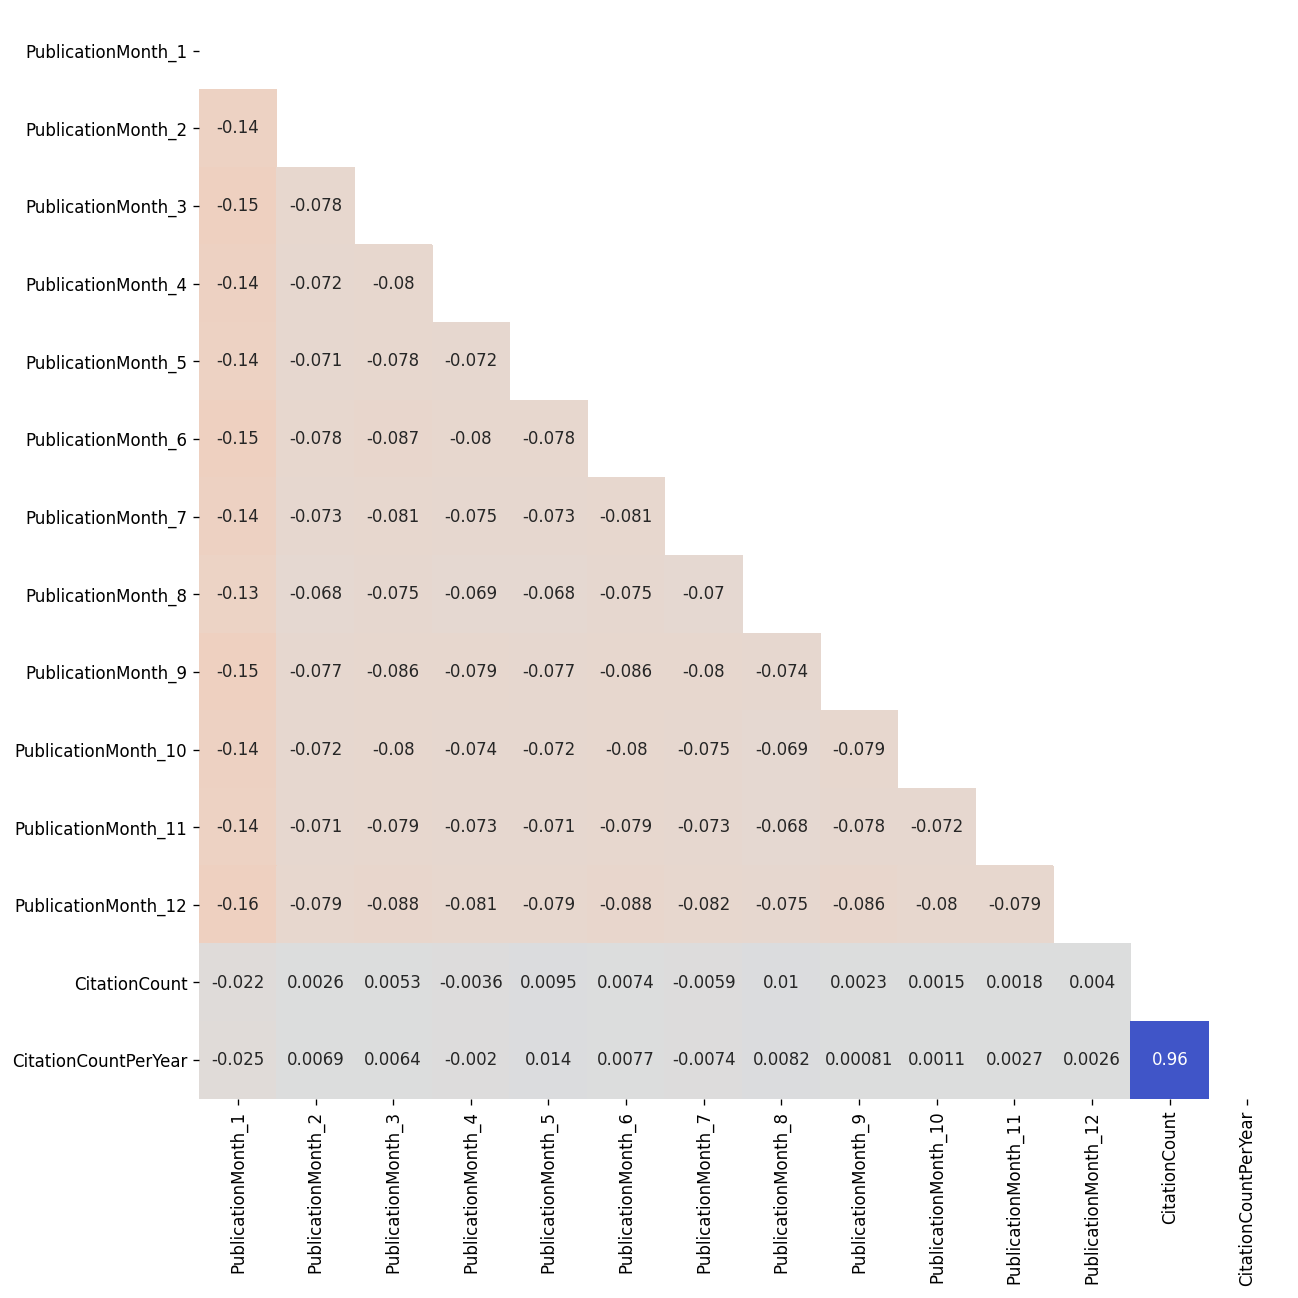

In [89]:
correlation(df, columns=publication_month_features+ [
    "CitationCount",
    "CitationCountPerYear"
])

In [90]:
# Add processed abstract col
from nlp_tools import (
    preprocess_text_col
)
df = df.assign(Processed_Abstract=preprocess_text_col(df["Abstract"]))

In [91]:
def add_normalized_rank_feature(df, col):
    avg_citations_by_column = df.groupby([col])["CitationCount"].mean()
    avg_citations_ranked_by_column = df.apply(lambda doc: avg_citations_by_column.loc[doc[col]], axis=1)

    df[col + "RankNormalized"] = avg_citations_ranked_by_column.rank(method="dense")
    return df

In [92]:
df = add_normalized_rank_feature(df, "JournalName")
df = add_normalized_rank_feature(df, "Publisher")

## Feature Analysis


Higher rank -> more citations


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa4e817e1c0>]],
      dtype=object)

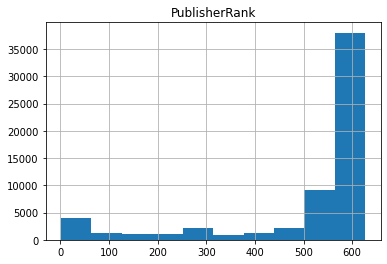

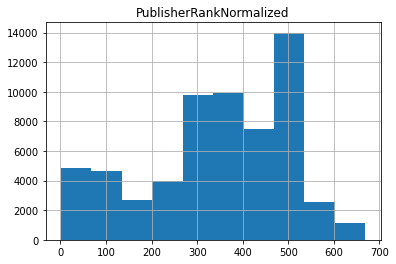

In [93]:
print("Higher rank -> more citations")
df.hist("PublisherRank")
df.hist("PublisherRankNormalized")

Higher rank -> more citations


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa5555e1b80>]],
      dtype=object)

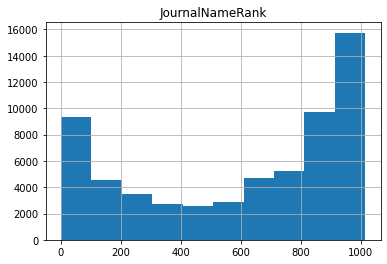

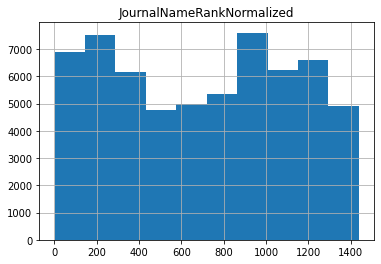

In [94]:
print("Higher rank -> more citations")
df.hist("JournalNameRank")
df.hist("JournalNameRankNormalized")

Higher rank -> more citations


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa51103e0a0>]],
      dtype=object)

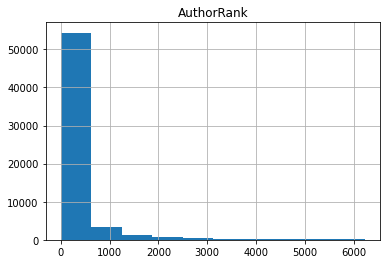

In [95]:
print("Higher rank -> more citations")
df.hist("AuthorRank")

PageCount max 99.0
PageCount mean 10.697946541241253
PageCount min 0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa514586880>]],
      dtype=object)

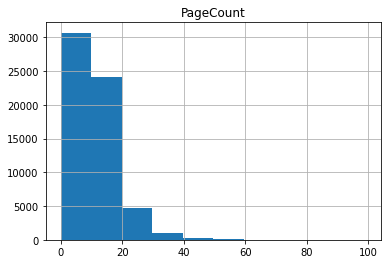

In [96]:
print("PageCount max", df["PageCount"].max())
print("PageCount mean", df["PageCount"].mean())
print("PageCount min", df["PageCount"].min())
df.hist("PageCount")

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

def correlation(df, columns=None, plot=True):
    t = df[columns] if columns else df
    if not plot:
        print(t.corr())
    else:
        fig = plt.figure(figsize=(12, 12), dpi=120)
        mask = np.triu(t.corr())
        sns.heatmap(
            t.corr(),
            mask=mask,
            cbar=False,
            square=True,
            annot=True,
            vmin=-1,
            vmax=1,
            center=0,
            cmap="coolwarm_r",
            linecolor="black",
        )
        
        plt.show()

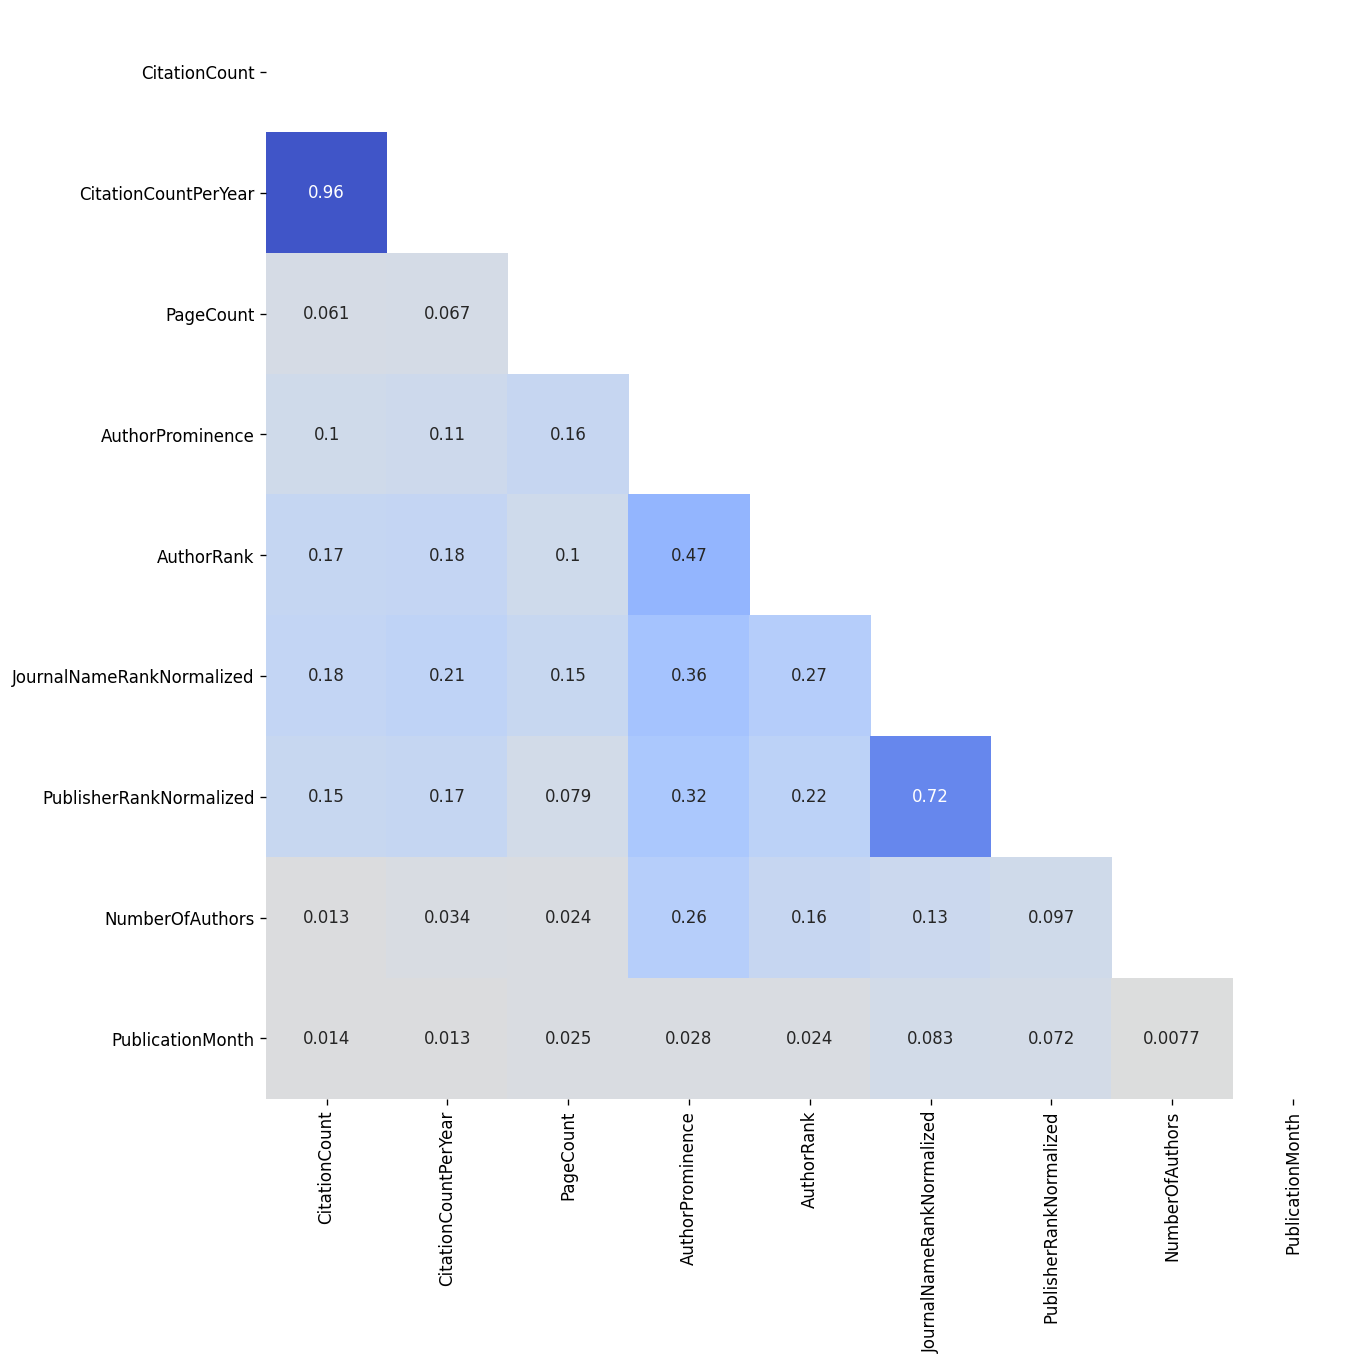

In [63]:

correlation(df, columns=[
    "CitationCount",
    "CitationCountPerYear",
    "PageCount",
    "AuthorProminence",
    "AuthorRank",
    "JournalNameRankNormalized",
    "PublisherRankNormalized",
    "NumberOfAuthors",
    "PublicationMonth",
    #"YearsSincePublication",
    #"JournalNameRank",
    #"PublisherRank",
    #"Rank"
])

In [98]:
filename = "../saved/final_dataset_cs_papers_last_20_v2.csv"
df.to_csv(filename, index_label="PaperId")

In [99]:
loaded_df = pd.read_csv(filename, index_col='PaperId')
loaded_df.shape

(61019, 51)

In [100]:
loaded_df.head()

,Abstract,Author_1,Author_10,Author_11,Author_2,Author_3,Author_4,Author_5,Author_6,Author_7,...,PublicationMonth_6,PublicationMonth_7,PublicationMonth_8,PublicationMonth_9,PublicationMonth_10,PublicationMonth_11,PublicationMonth_12,Processed_Abstract,JournalNameRankNormalized,PublisherRankNormalized
PaperId,,,,,,,,,,,,,,,,,,,,,
2013266033,Two important automation characteristics are c...,1976502312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,important automation characteristic crucial co...,1319.0,479.0
2147483915,Many Internet of Things (IoT) technologies h...,2141485328,NaN,NaN,2.713835e+09,2.226086e+09,2.224880e+09,2.231733e+09,NaN,NaN,...,0,0,0,0,0,0,1,many internet things iot technology use applic...,1243.0,478.0
2147483970,This paper deals with an application of wavele...,2275778229,NaN,NaN,2.779769e+09,1.355326e+09,2.095098e+09,NaN,NaN,NaN,...,0,0,0,0,0,0,1,this paper deal application wavelet feature ex...,888.0,363.0
2013266260,An object-to-object color mapping method based...,2135137024,NaN,NaN,2.131763e+09,2.106423e+09,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,an object object color map method base image s...,624.0,303.0
2013266632,"We present a distributed, integrated medium ac...",2304913869,NaN,NaN,2.124193e+09,2.030774e+09,2.091976e+08,4.341810e+08,NaN,NaN,...,0,0,0,1,0,0,0,we present distribute integrate medium access ...,1183.0,478.0


In [101]:
loaded_df.columns

Index(['Abstract', 'Author_1', 'Author_10', 'Author_11', 'Author_2',
       'Author_3', 'Author_4', 'Author_5', 'Author_6', 'Author_7', 'Author_8',
       'Author_9', 'CitationCount', 'CitationCountPerYear', 'FieldOfStudy_0',
       'FieldOfStudy_1', 'FieldOfStudy_2', 'FieldOfStudy_3', 'FieldOfStudy_4',
       'FieldOfStudy_5', 'FirstPage', 'JournalName', 'LastPage',
       'PublishedDate', 'Publisher', 'Rank', 'Title', 'YearsSincePublication',
       'AuthorProminence', 'MagBin', 'CitationBin', 'AuthorRank',
       'JournalNameRank', 'PublisherRank', 'PageCount', 'NumberOfAuthors',
       'PublicationMonth_1', 'PublicationMonth_2', 'PublicationMonth_3',
       'PublicationMonth_4', 'PublicationMonth_5', 'PublicationMonth_6',
       'PublicationMonth_7', 'PublicationMonth_8', 'PublicationMonth_9',
       'PublicationMonth_10', 'PublicationMonth_11', 'PublicationMonth_12',
       'Processed_Abstract', 'JournalNameRankNormalized',
       'PublisherRankNormalized'],
      dtype='object')